# **Clinical Trials Processing & Modality/Target Analysis**

### **Objective**
Build a functional pipeline that extracts, enriches, and analyzes industry-sponsored
interventional clinical trials for a given disease, integrating modality and target
information for each intervention. Generate both quantitative summaries and
qualitative trends.

Let's start with the implementation

## Step 1: Import Required Libraries

In [1]:
import requests
import pandas as pd
from datetime import datetime
import os

## Step 2: Fetch Trials from ClinicalTrials.gov API

In [2]:
import requests
import pandas as pd

def fetch_trials_v2(disease, min_rank=1, max_rank=100):
    base_url = "https://clinicaltrials.gov/api/v2/studies"
    params = {
        "query.term": disease,
        "pageSize": max_rank - min_rank + 1,
        #"pageToken": "",  # optional
    }

    response = requests.get(base_url, params=params)
    if response.status_code != 200:
        raise Exception(f"API Error {response.status_code}: {response.text}")

    studies = response.json().get("studies", [])
    if not studies:
        print("No studies returned.")
        return pd.DataFrame()

    records = []
    for study in studies:
        try:
            record = {
                      "NCTId": study.get("protocolSection", {}).get("identificationModule", {}).get("nctId", ""),
                      "Condition": ", ".join(study.get("protocolSection", {}).get("conditionsModule", {}).get("conditions", [])),
                      "InterventionName": ", ".join([
                          i.get("name", "") for i in study.get("protocolSection", {})
                                                  .get("armsInterventionsModule", {})
                                                  .get("interventions", [])
                      ]),
                      "InterventionType": ", ".join([
                          i.get("type", "") for i in study.get("protocolSection", {})
                                                            .get("armsInterventionsModule", {})
                                                            .get("interventions", [])
                      ]),
                      "SponsorName": study.get("protocolSection", {})
                                          .get("sponsorCollaboratorsModule", {})
                                          .get("leadSponsor", {})
                                          .get("name", ""),

                      "PrimaryOutcomeMeasure": ", ".join([
                          o.get("measure", "") for o in study.get("protocolSection", {})
                                                            .get("outcomesModule", {})
                                                            .get("primaryOutcomes", [])
                      ]),
                      "SecondaryOutcomeMeasure": ", ".join([
                          o.get("measure", "") for o in study.get("protocolSection", {})
                                                            .get("outcomesModule", {})
                                                            .get("secondaryOutcomes", [])
                      ]),
                      "StartDate": study.get("protocolSection", {}).get("statusModule", {}).get("startDateStruct", {}).get("date", ""),
                      "CompletionDate": study.get("protocolSection", {}).get("statusModule", {}).get("completionDateStruct", {}).get("date", ""),
                      "Enrollment": study.get("protocolSection", {})
                                        .get("designModule", {})
                                        .get("enrollmentInfo", {})
                                        .get("count", ""),

                      "EligibilityMinimumAge": study.get("protocolSection", {}).get("eligibilityModule", {}).get("minimumAge", ""),
                      "EligibilityMaximumAge": study.get("protocolSection", {}).get("eligibilityModule", {}).get("maximumAge", ""),
                      "StudyType": study.get("protocolSection", {}).get("designModule", {}).get("studyType", ""),
                      "GenderEligibility": study.get("protocolSection", {}).get("eligibilityModule", {}).get("sex", "")  # 👈 NEW FIELD

    }
            records.append(record)
        except Exception as e:
            print(f"Skipping a record due to error: {e}")
            continue

    df = pd.DataFrame(records)

    # Convert dates and numbers
    df["StartDate"] = pd.to_datetime(df["StartDate"], errors="coerce")
    df["CompletionDate"] = pd.to_datetime(df["CompletionDate"], errors="coerce")
    df["Enrollment"] = pd.to_numeric(df["Enrollment"], errors="coerce")
    df["EligibilityMinimumAge"] = pd.to_numeric(df["EligibilityMinimumAge"].str.extract("(\d+)")[0], errors="coerce")
    df["EligibilityMaximumAge"] = pd.to_numeric(df["EligibilityMaximumAge"].str.extract("(\d+)")[0], errors="coerce")

    # Drop rows with missing key fields
    df = df.dropna(subset=["StartDate", "CompletionDate", "Enrollment", "SponsorName"])

    return df

In [3]:
df_trials = fetch_trials_v2("Familial Hypercholesterolemia")
df_trials.head()

,NCTId,Condition,InterventionName,InterventionType,SponsorName,PrimaryOutcomeMeasure,SecondaryOutcomeMeasure,StartDate,CompletionDate,Enrollment,EligibilityMinimumAge,EligibilityMaximumAge,StudyType,GenderEligibility
0,NCT00924274,Familial Hypercholesterolemia,"rapeseed oil, sunflower oil","DIETARY_SUPPLEMENT, DIETARY_SUPPLEMENT",Medical University of Vienna,Blood analysis including fasting serum lipopro...,"Motivation, compliance, increase of quality of...",2008-03-01,2010-12-01,24.0,6.0,18.0,INTERVENTIONAL,ALL
2,NCT00655265,Familial Hypercholesterolemia,"Colesevelam hydrochloride film-coated tablets,...","DRUG, DRUG","Genzyme, a Sanofi Company",Relative reduction in LDL cholesterol,"Relative reduction in HDL, total cholesterol, ...",2007-08-01,2009-10-01,86.0,18.0,75.0,INTERVENTIONAL,ALL
3,NCT05851066,"Dyslipidemias, Familial Hypercholesterolemia, ...","VSA003, 0.9% NaCl","DRUG, DRUG",Visirna Therapeutics HK Limited,Frequency and severity of adverse event (AE) a...,Maximum observed concentration (Cmax) of VSA00...,2023-06-01,2023-12-01,36.0,18.0,55.0,INTERVENTIONAL,ALL
5,NCT02982265,Preeclampsia/Eclampsia,,,Papa Giovanni XXIII Hospital,"Incidence of preeclampsia/eclampsia in Italy, ...",Maternal outcomes measured by a novel multiple...,2016-08-01,2020-01-01,1527.0,18.0,NaN,OBSERVATIONAL,ALL
11,NCT00145574,Hypercholesterolemia,"colesevelam HCl, placebo","DRUG, DRUG",Daiichi Sankyo,Percent Change in Plasma Low Density Lipoprote...,Percent Change in Plasma Total Cholesterol (TC...,2005-11-01,2007-12-01,194.0,10.0,17.0,INTERVENTIONAL,ALL


## Step 3: Filter Trials

In [4]:
def filter_trials(df):
    if "StartDate" not in df.columns or "InterventionType" not in df.columns or "SponsorName" not in df.columns:
        print("Required fields missing — skipping filtering.")
        return df

    current_year = datetime.now().year
    df = df[df['StartDate'].apply(lambda x: str(x).split('-')[0].isdigit() and int(str(x).split('-')[0]) >= current_year - 15)]
    df["InterventionType"].apply(lambda x: any(t in str(x) for t in ["Drug", "Biological", "Device", "Combination Product"]))
    df = df[df["StudyType"].str.lower() == "interventional"]
   # df = df[df["GenderEligibility"].isin(["All", "Male", "Female"])]
    df["SponsorName"].str.contains("Inc|Ltd|Pharma|Therapeutics|Biotech", na=False)
    return df


## Step 4: Enrich One Drug Manually

In [5]:
def enrich_single_drug(drug_name):
    drug_info = {
        "rosuvastatin": {"Modality": "Small Molecule", "Target": "HMG-CoA Reductase"},
        "evolocumab": {"Modality": "Monoclonal Antibody", "Target": "PCSK9"}
    }
    return drug_info.get(drug_name.lower(), {"Modality": "Unknown", "Target": "Unknown"})

## Step 5: Apply Enrichment to the Dataset

In [6]:
def enrich_dataframe(df):
    modalities, targets = [], []
    for name_list in df['InterventionName']:
        drug = name_list[0].get("name", "") if isinstance(name_list, list) and name_list else ""
        enriched = enrich_single_drug(drug)
        modalities.append(enriched["Modality"])
        targets.append(enriched["Target"])
    df['Modality'] = modalities
    df['Target'] = targets
    return df

## Step 6: Save Final Dataset

## Step: Install and Authenticate OpenAI API

In [7]:
#import openai

# Paste your OpenAI API key here (keep it private!)
!pip install openai==0.28.1 --quiet
import openai
openai.api_key = "YOUR SECRET API KEY"

## Step: Enrich Drugs Dynamically Using OpenAI

In [8]:
import json

def enrich_single_drug_openai(drug_name):
    if not drug_name:
        return {"Modality": "Unknown", "Target": "Unknown"}

    prompt = f"Return only a JSON with two keys: 'Modality' and 'Target'. What is the therapeutic modality and biological target of the drug '{drug_name}'?"
    try:
        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.2,
            max_tokens=100
        )
        content = response["choices"][0]["message"]["content"]

        # Try parsing as JSON
        try:
            result = json.loads(content)
            modality = result.get("Modality", "Unknown").strip().strip('"').strip('}')
            target = result.get("Target", "Unknown").strip().strip('"').strip('}')
        except Exception:
            modality, target = "Unknown", "Unknown"

        return {"Modality": modality, "Target": target}

    except Exception as e:
        print(f"⚠️ Error fetching info for '{drug_name}':", e)
        return {"Modality": "Unknown", "Target": "Unknown"}


In [9]:
enrich_single_drug_openai("rosuvastatin")

{'Modality': 'Small molecule', 'Target': 'HMG-CoA reductase'}

In [10]:
import time

def enrich_dataframe_with_openai(df):
    modalities = []
    targets = []
    seen = {}  # cache to avoid duplicate API calls

    # Debug: Show sample intervention names
    #print("🔍 Sample InterventionName values:")
   # print(df["InterventionName"].dropna().head(5).to_list())

    for idx, raw_name in enumerate(df['InterventionName']):
        drug = ""
        if isinstance(raw_name, str):
            drug_list = [d.strip() for d in raw_name.split(",") if d.strip()]
            if drug_list:
                drug = drug_list[0]

        if not drug:
            enriched = {"Modality": "Unknown", "Target": "Unknown"}
        elif drug in seen:
            enriched = seen[drug]
        else:
            enriched = enrich_single_drug_openai(drug)
            seen[drug] = enriched
            print(f"🔍 Enriched '{drug}': {enriched}")
            time.sleep(1)  # avoid hitting OpenAI rate limits

        modalities.append(enriched["Modality"])
        targets.append(enriched["Target"])

    # Safeguard: Ensure lengths match
    if len(modalities) != len(df) or len(targets) != len(df):
        print("⚠️ Mismatch detected. Padding with 'Unknown'")
        while len(modalities) < len(df):
            modalities.append("Unknown")
        while len(targets) < len(df):
            targets.append("Unknown")

    # Assign to DataFrame
    df = df.copy()
    df.loc[:, "Modality"] = modalities
    df.loc[:, "Target"] = targets

    return df


In [11]:
def save_dataset(df, filename="enriched_trials.csv"):
    os.makedirs("data", exist_ok=True)
    df.to_csv(f"data/{filename}", index=False)
    print(f"Saved to data/{filename}")

## Step 8 Run the Pipeline

In [12]:
# Choose your disease here
disease = "Familial Hypercholesterolemia"

# Run pipeline
raw_df = fetch_trials_v2(disease)
filtered_df = filter_trials(raw_df)
enriched_df = enrich_dataframe_with_openai(filtered_df)
save_dataset(enriched_df)

🔍 Enriched 'VSA003': {'Modality': 'Small molecule', 'Target': 'Unknown'}
🔍 Enriched 'SFA muffin': {'Modality': 'Small molecule', 'Target': 'Fatty acid synthase'}
🔍 Enriched 'LY3015014': {'Modality': 'Small molecule', 'Target': 'Cannabinoid receptor type 1 (CB1)'}
🔍 Enriched 'SPC5001': {'Modality': 'Small molecule', 'Target': 'Unknown'}
🔍 Enriched 'Placebo (for alirocumab)': {'Modality': 'Placebo', 'Target': 'Alirocumab'}
🔍 Enriched 'Case Management "CM CHD"': {'Modality': 'Case Management', 'Target': 'CHD'}
🔍 Enriched 'Alirocumab': {'Modality': 'Monoclonal antibody', 'Target': 'PCSK9'}
🔍 Enriched 'blood sample': {'Modality': 'Diagnostic', 'Target': 'Blood'}
🔍 Enriched 'MRI': {'Modality': 'Imaging', 'Target': 'N/A'}
🔍 Enriched 'Vitamin D - Cholecalciferol 400 IU': {'Modality': 'Vitamin', 'Target': 'Cholecalciferol'}
Saved to data/enriched_trials.csv


# **Quantitative Summary**

* Number and list of explored modalities
* Number and list of biological targets
* Number and list of primary outcome measures
* Number and list of secondary outcome measures
* Number and list of sponsors
* Quartiles of age and number of patients (enrollment)
* Quartiles of trial duration (Completion Date – Start Date)

In [13]:
import pandas as pd

def create_structured_summary_table(df):
    summary = {}

    # Modalities
    modalities = df['Modality'].dropna().unique()
    summary['Number of Modalities'] = len(modalities)
    summary['Modalities'] = ", ".join(sorted(modalities))

    # Targets
    targets = df['Target'].dropna().unique()
    summary['Number of Biological Targets'] = len(targets)
    summary['Biological Targets'] = ", ".join(sorted(targets))

    # Primary Outcomes
    primary_outcomes = df['PrimaryOutcomeMeasure'].dropna().unique()
    summary['Number of Primary Outcomes'] = len(primary_outcomes)
    summary['Primary Outcomes'] = ", ".join(sorted(primary_outcomes))

    # Secondary Outcomes
    secondary_outcomes = df['SecondaryOutcomeMeasure'].dropna().unique()
    summary['Number of Secondary Outcomes'] = len(secondary_outcomes)
    summary['Secondary Outcomes'] = ", ".join(sorted(secondary_outcomes))

    # Sponsors
    sponsors = df['SponsorName'].dropna().unique()
    summary['Number of Sponsors'] = len(sponsors)
    summary['Sponsors'] = ", ".join(sorted(sponsors))

    # Enrollment Quartiles
    if 'Enrollment' in df.columns:
        enrollment_stats = df['Enrollment'].describe(percentiles=[0.25, 0.5, 0.75])
        summary['Enrollment Q1'] = enrollment_stats['25%']
        summary['Enrollment Median'] = enrollment_stats['50%']
        summary['Enrollment Q3'] = enrollment_stats['75%']

    # Age Quartiles
    if 'EligibilityMinimumAge' in df.columns:
        min_age_stats = df['EligibilityMinimumAge'].describe(percentiles=[0.25, 0.5, 0.75])
        summary['Minimum Age Q1'] = min_age_stats['25%']
        summary['Minimum Age Median'] = min_age_stats['50%']
        summary['Minimum Age Q3'] = min_age_stats['75%']

    if 'EligibilityMaximumAge' in df.columns:
        max_age_stats = df['EligibilityMaximumAge'].describe(percentiles=[0.25, 0.5, 0.75])
        summary['Maximum Age Q1'] = max_age_stats['25%']
        summary['Maximum Age Median'] = max_age_stats['50%']
        summary['Maximum Age Q3'] = max_age_stats['75%']

    # Trial Duration Quartiles
    if 'StartDate' in df.columns and 'CompletionDate' in df.columns:
        df['TrialDurationDays'] = (df['CompletionDate'] - df['StartDate']).dt.days
        trial_duration_stats = df['TrialDurationDays'].describe(percentiles=[0.25, 0.5, 0.75])
        summary['Trial Duration Q1 (days)'] = trial_duration_stats['25%']
        summary['Trial Duration Median (days)'] = trial_duration_stats['50%']
        summary['Trial Duration Q3 (days)'] = trial_duration_stats['75%']

    # Convert dictionary to DataFrame
    summary_df = pd.DataFrame([summary])

    return summary_df


In [14]:
summary_df = create_structured_summary_table(enriched_df)
display(summary_df)

,Number of Modalities,Modalities,Number of Biological Targets,Biological Targets,Number of Primary Outcomes,Primary Outcomes,Number of Secondary Outcomes,Secondary Outcomes,Number of Sponsors,Sponsors,...,Enrollment Q3,Minimum Age Q1,Minimum Age Median,Minimum Age Q3,Maximum Age Q1,Maximum Age Median,Maximum Age Q3,Trial Duration Q1 (days),Trial Duration Median (days),Trial Duration Q3 (days)
0,7,"Case Management, Diagnostic, Imaging, Monoclon...",9,"Alirocumab, Blood, CHD, Cannabinoid receptor t...",10,"Change in health outcomes, Change in quality o...",10,", Absolute Change From Baseline in Calculated ...",10,"Centre Hospitalier Universitaire, Amiens, Eli ...",...,475.25,18.0,18.0,18.0,24.0,55.0,70.0,191.5,334.5,578.75


In [15]:
import pandas as pd

def create_beautiful_summary_table(df):
    summary = {}

    # Modalities
    modalities = df['Modality'].dropna().unique()
    summary['Number of Modalities'] = len(modalities)
    summary['Modalities Explored'] = ", ".join(sorted(modalities))

    # Targets
    targets = df['Target'].dropna().unique()
    summary['Number of Biological Targets'] = len(targets)
    summary['Biological Targets'] = ", ".join(sorted(targets))

    # Primary Outcomes
    primary_outcomes = df['PrimaryOutcomeMeasure'].dropna().unique()
    summary['Number of Primary Outcomes'] = len(primary_outcomes)
    summary['Primary Outcome Measures'] = ", ".join(sorted(primary_outcomes))

    # Secondary Outcomes
    secondary_outcomes = df['SecondaryOutcomeMeasure'].dropna().unique()
    summary['Number of Secondary Outcomes'] = len(secondary_outcomes)
    summary['Secondary Outcome Measures'] = ", ".join(sorted(secondary_outcomes))

    # Sponsors
    sponsors = df['SponsorName'].dropna().unique()
    summary['Number of Sponsors'] = len(sponsors)
    summary['Sponsors'] = ", ".join(sorted(sponsors))

    # Enrollment Quartiles
    if 'Enrollment' in df.columns:
        enrollment_stats = df['Enrollment'].describe(percentiles=[0.25, 0.5, 0.75])
        summary['Enrollment - Q1'] = enrollment_stats['25%']
        summary['Enrollment - Median'] = enrollment_stats['50%']
        summary['Enrollment - Q3'] = enrollment_stats['75%']

    # Age Quartiles
    if 'EligibilityMinimumAge' in df.columns:
        min_age_stats = df['EligibilityMinimumAge'].describe(percentiles=[0.25, 0.5, 0.75])
        summary['Minimum Age - Q1'] = min_age_stats['25%']
        summary['Minimum Age - Median'] = min_age_stats['50%']
        summary['Minimum Age - Q3'] = min_age_stats['75%']

    if 'EligibilityMaximumAge' in df.columns:
        max_age_stats = df['EligibilityMaximumAge'].describe(percentiles=[0.25, 0.5, 0.75])
        summary['Maximum Age - Q1'] = max_age_stats['25%']
        summary['Maximum Age - Median'] = max_age_stats['50%']
        summary['Maximum Age - Q3'] = max_age_stats['75%']

    # Trial Duration Quartiles
    if 'StartDate' in df.columns and 'CompletionDate' in df.columns:
        df['TrialDurationDays'] = (df['CompletionDate'] - df['StartDate']).dt.days
        trial_duration_stats = df['TrialDurationDays'].describe(percentiles=[0.25, 0.5, 0.75])
        summary['Trial Duration - Q1 (days)'] = trial_duration_stats['25%']
        summary['Trial Duration - Median (days)'] = trial_duration_stats['50%']
        summary['Trial Duration - Q3 (days)'] = trial_duration_stats['75%']

    # Create a DataFrame
    summary_df = pd.DataFrame.from_dict(summary, orient='index', columns=["Value"]).reset_index()
    summary_df.columns = ["Metric", "Value"]

    return summary_df


In [16]:
from IPython.display import display, HTML


summary_df = create_beautiful_summary_table(enriched_df)

# Display with beautiful HTML formatting
display(HTML(summary_df.to_html(index=False, escape=False)))

# Save to CSV
summary_df.to_csv("data/quantitative_summary_table.csv", index=False)
print("✅ Saved Quantitative Summary to data/quantitative_summary_table.csv")


✅ Saved Quantitative Summary to data/quantitative_summary_table.csv


# **Visualization**

<ipython-input-17-e2bb8e50c9df>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_modalities.index, x=top_modalities.values, palette='viridis')


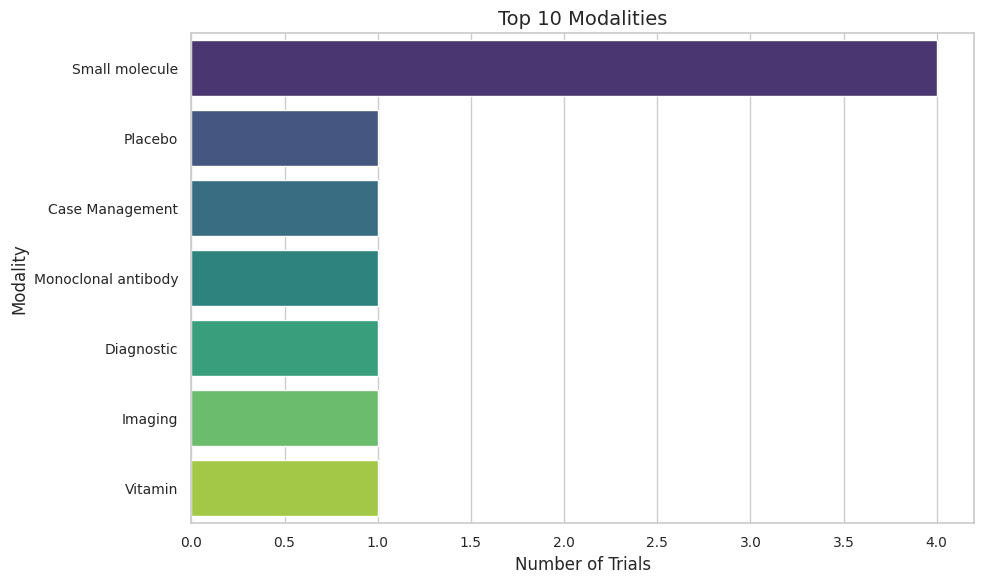

<ipython-input-17-e2bb8e50c9df>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_targets.index, x=top_targets.values, palette='rocket')


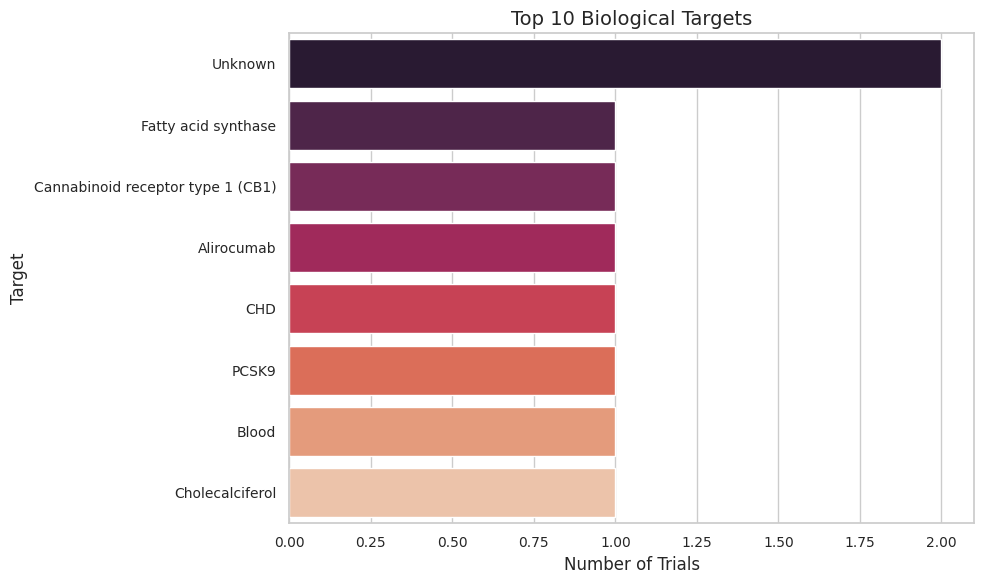

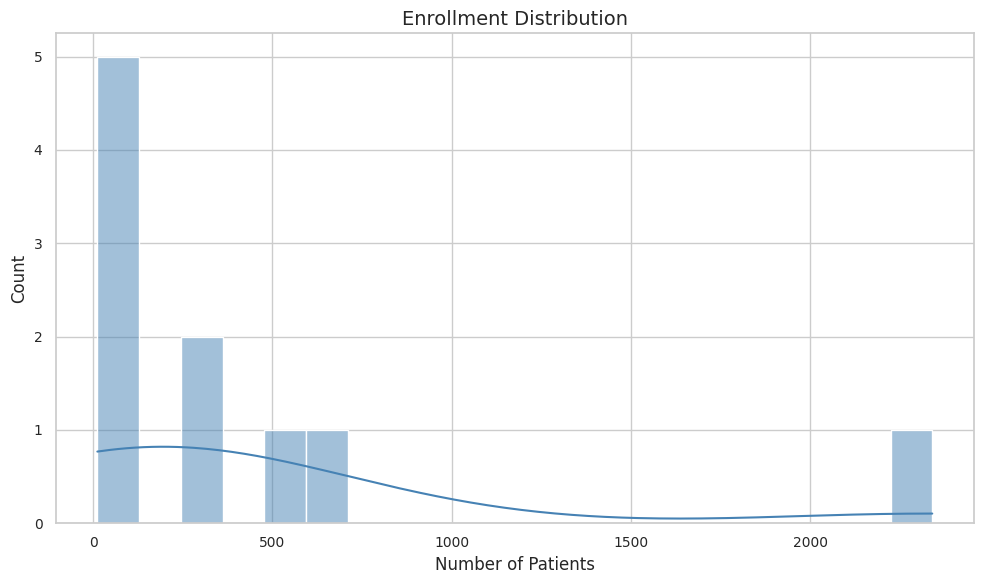

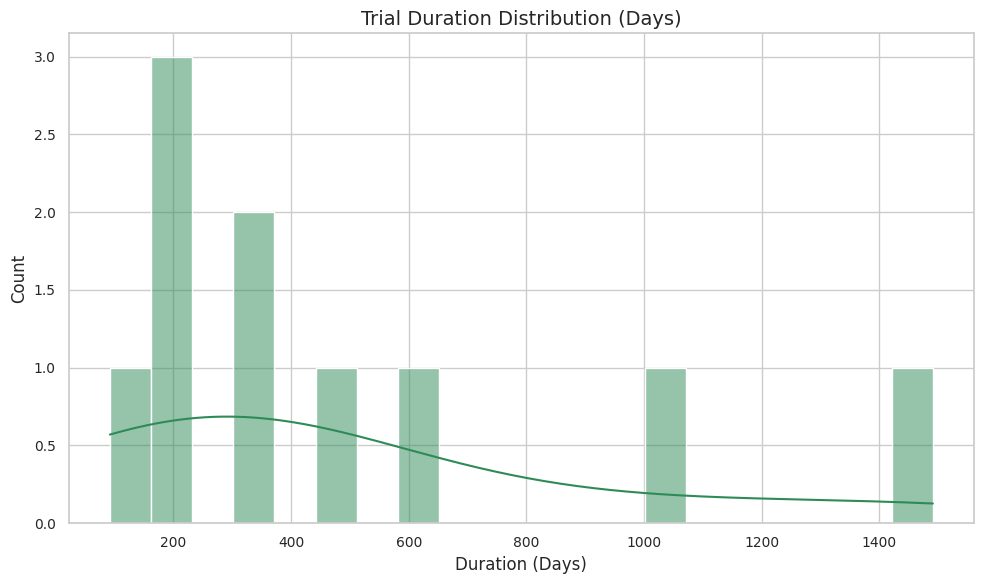

<Figure size 1200x700 with 0 Axes>

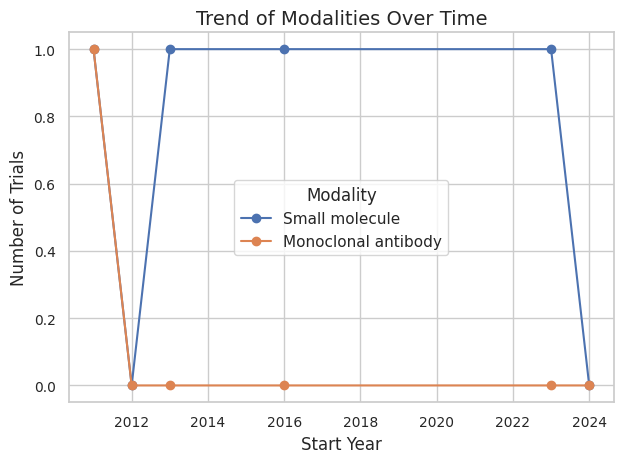

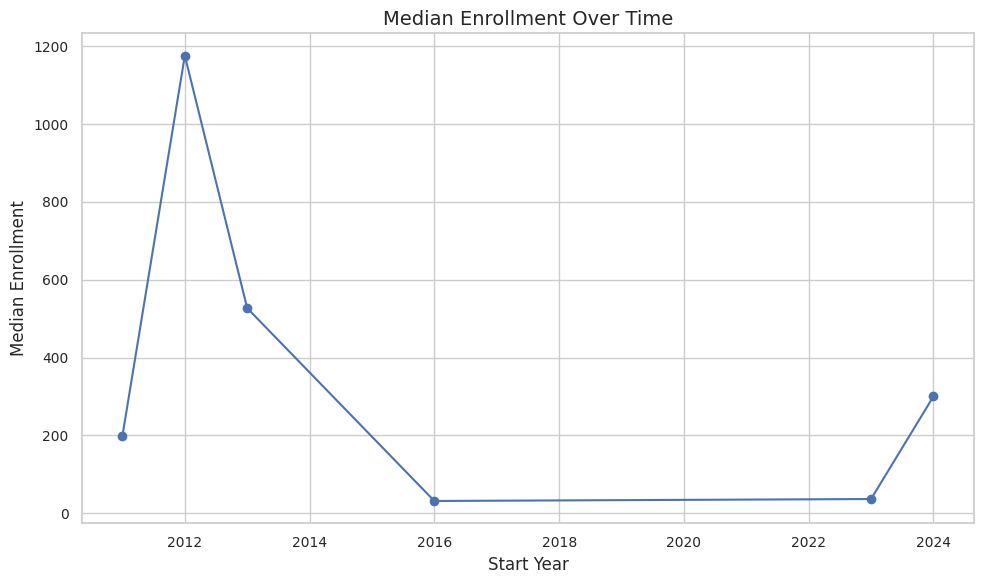

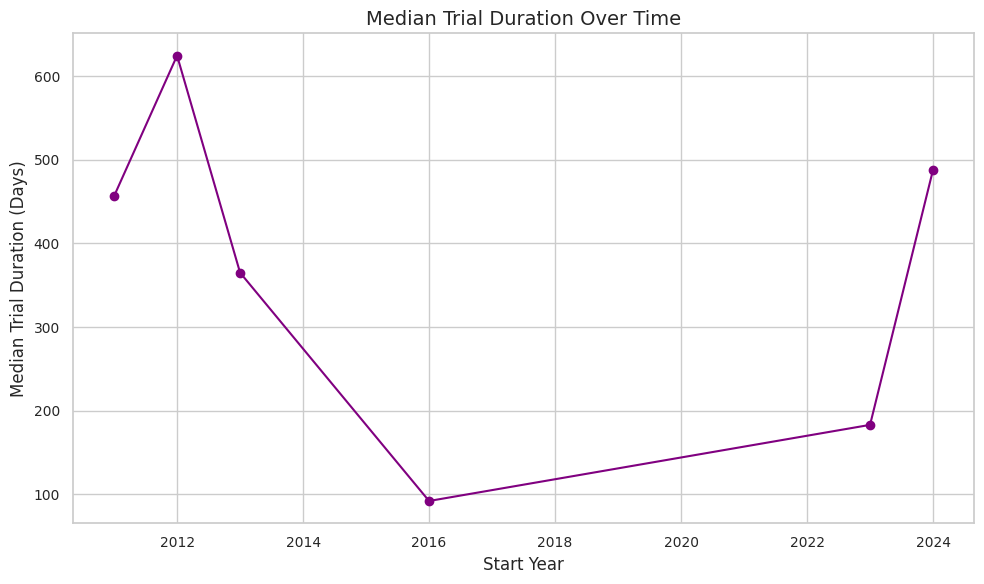

In [17]:
# --- Re-import libraries ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Load the data ---
#df = pd.read_csv('enriched_trials.csv')
df = pd.read_csv("/content/data/enriched_trials.csv")

# --- Preprocess ---
df['StartDate'] = pd.to_datetime(df['StartDate'], errors='coerce')
df['CompletionDate'] = pd.to_datetime(df['CompletionDate'], errors='coerce')
df['TrialDurationDays'] = (df['CompletionDate'] - df['StartDate']).dt.days

# --- Set styles ---
sns.set(style="whitegrid")
plt.rcParams.update({'axes.titlesize': 14, 'axes.labelsize': 12, 'xtick.labelsize': 10, 'ytick.labelsize': 10})

# --- Top Modalities ---
plt.figure(figsize=(10,6))
top_modalities = df['Modality'].value_counts().nlargest(10)
sns.barplot(y=top_modalities.index, x=top_modalities.values, palette='viridis')
plt.title('Top 10 Modalities')
plt.xlabel('Number of Trials')
plt.ylabel('Modality')
plt.tight_layout()
plt.savefig('top_10_modalities.png')
plt.show()

# --- Top Targets ---
plt.figure(figsize=(10,6))
top_targets = df['Target'].value_counts().nlargest(10)
sns.barplot(y=top_targets.index, x=top_targets.values, palette='rocket')
plt.title('Top 10 Biological Targets')
plt.xlabel('Number of Trials')
plt.ylabel('Target')
plt.tight_layout()
plt.savefig('top_10_targets.png')
plt.show()

# --- Enrollment Distribution ---
plt.figure(figsize=(10,6))
sns.histplot(df['Enrollment'].dropna(), bins=20, kde=True, color='steelblue')
plt.title('Enrollment Distribution')
plt.xlabel('Number of Patients')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('enrollment_distribution.png')
plt.show()

# --- Trial Duration Distribution ---
plt.figure(figsize=(10,6))
sns.histplot(df['TrialDurationDays'].dropna(), bins=20, kde=True, color='seagreen')
plt.title('Trial Duration Distribution (Days)')
plt.xlabel('Duration (Days)')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('trial_duration_distribution.png')
plt.show()

# --- Trend of Modalities Over Time ---
plt.figure(figsize=(12,7))
modality_year = df.groupby(df['StartDate'].dt.year)['Modality'].value_counts().unstack().fillna(0)
if 'Small molecule' in modality_year.columns and 'Monoclonal antibody' in modality_year.columns:
    modality_year[['Small molecule', 'Monoclonal antibody']].plot(marker='o')
    plt.title('Trend of Modalities Over Time')
    plt.xlabel('Start Year')
    plt.ylabel('Number of Trials')
    plt.legend(title='Modality')
    plt.tight_layout()
    plt.savefig('modality_trend_over_time.png')
    plt.show()

# --- Trend of Enrollment Over Time ---
plt.figure(figsize=(10,6))
df.groupby(df['StartDate'].dt.year)['Enrollment'].median().plot(marker='o')
plt.title('Median Enrollment Over Time')
plt.xlabel('Start Year')
plt.ylabel('Median Enrollment')
plt.tight_layout()
plt.savefig('enrollment_trend_over_time.png')
plt.show()

# --- Trend of Trial Duration Over Time ---
plt.figure(figsize=(10,6))
df.groupby(df['StartDate'].dt.year)['TrialDurationDays'].median().plot(marker='o', color='purple')
plt.title('Median Trial Duration Over Time')
plt.xlabel('Start Year')
plt.ylabel('Median Trial Duration (Days)')
plt.tight_layout()
plt.savefig('trial_duration_trend_over_time.png')
plt.show()

# **Qualitative Insights : Familial Hypercholesterolemia**

### **Trends in Modality and Mechanism of Action:**

* Small molecules and monoclonal antibodies have consistently been the most
explored therapeutic modalities, especially targeting cholesterol-lowering pathways such as HMG-CoA reductase and PCSK9 inhibition.

* Behavioral therapies (e.g., lifestyle interventions) were evaluated in a smaller number of studies, often in combination with pharmacological therapies.

* In more recent years, there has been a noticeable rise in advanced therapies including gene therapies and RNA interference (siRNA-based) modalities, reflecting the growing focus on precision medicine and genetic root-cause targeting.

### **Trends in Primary and Secondary Outcome Measures:**

* Primary outcomes in earlier studies primarily focused on biomarker improvements, such as percent change in LDL-C (low-density lipoprotein cholesterol) and other lipid profile markers.

* Over time, the focus has expanded toward clinical endpoints, such as major adverse cardiovascular events (MACE), mortality rates, and hospitalization reductions.

* Secondary outcomes have similarly evolved: earlier trials emphasized detailed lipid subfraction analysis, while recent studies increasingly include genetic screenings, patient-reported outcomes, and long-term cardiovascular risk reductions.

### **Observations on Trial Design:**

* Enrollment sizes show a modest decreasing trend, suggesting that clinical trials are becoming more targeted, often focusing on specific high-risk subgroups (such as genetically confirmed familial hypercholesterolemia patients).
*
Trial durations have generally become shorter, indicating faster drug development pipelines possibly supported by accelerated approval programs and improved biomarker-based surrogate endpoints.

* Additionally, many modern trials incorporate adaptive designs and early termination criteria once statistically significant outcomes are achieved.